# Name: *Subham Dutta*
# Company: *INSAID*
# Task: 
### Develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan. Requires both statistical analysis and creativity/judgment and interpreting the results of your machine learning model.



In [2]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
data1 = pd.read_csv('Fraud.csv',sep=',')
data1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data1.isnull().values.any()

False

In [6]:
data1['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Text(0, 0.5, 'Frequency')

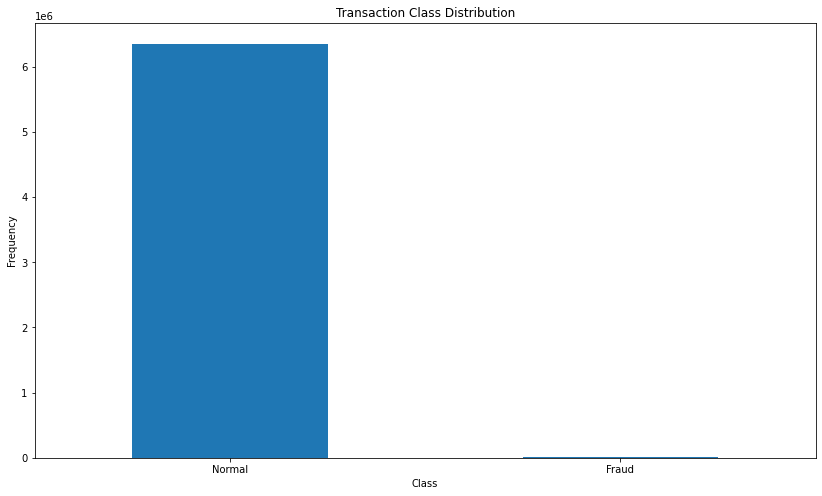

In [7]:
count_classes = pd.value_counts(data1['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

## This Dataset is highly unblanced

### 0 --> Normal Transaction

### 1 --> fraudulent transaction

In [8]:
# separating the data for analysis

normal = data1[data1['isFraud'] == 0]
fraud = data1[data1['isFraud'] == 1]

In [9]:
print(fraud.shape,normal.shape)

(8213, 11) (6354407, 11)


### We need to analyze more amount of information from the transaction data
### How different are the amount of money used in different transaction classes?

In [10]:
normal.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

In [11]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

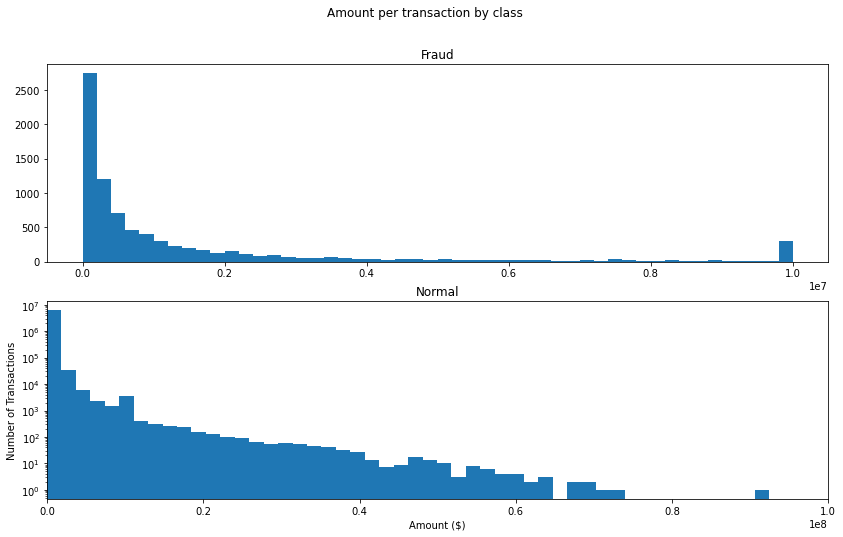

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 100000000))
plt.yscale('log')
plt.show();

In [13]:
outlier_fraction = len(fraud)/float(len(normal))

print(outlier_fraction)

print("Fraud Cases : {}".format(len(fraud)))

print("Valid Cases : {}".format(len(normal)))

0.0012924888191769902
Fraud Cases : 8213
Valid Cases : 6354407


## Correlation

### Get correlations of each features in dataset

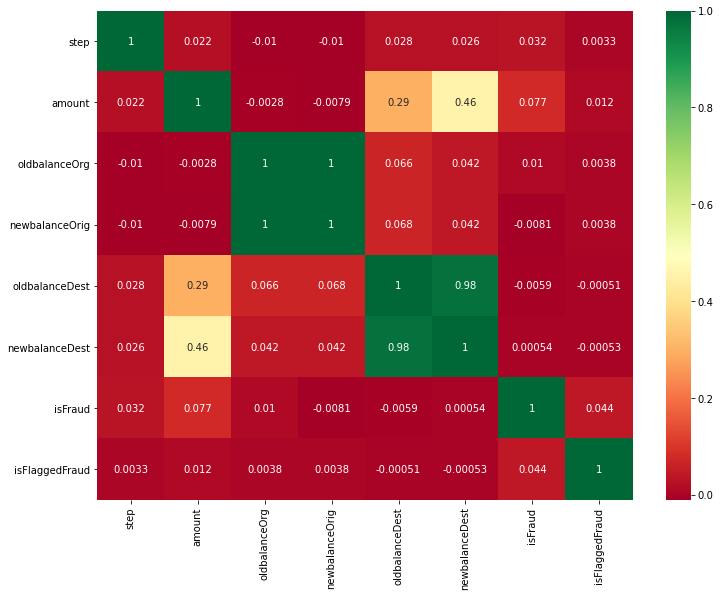

In [14]:
corrmat = data1.corr()
plt.figure(figsize=(12,9))
g=sns.heatmap(corrmat,annot=True,cmap="RdYlGn")

In [15]:
#Taking a fraction of data for ease of execution
data= data1.sample(frac = 0.01,random_state=1)

In [17]:
data.shape

(63626, 11)

In [18]:
columns = data.columns.tolist()
 
columns = [c for c in columns if c not in ["isFraud",'type','nameOrig','nameDest']]

target = "isFraud"

state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

print(X.shape)
print(Y.shape)

(63626, 7)
(63626,)


## Model Prediction
Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows

### Isolation Forest Algorithm :
One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.
How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

### Local Outlier Factor(LOF) Algorithm
The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.
The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [28]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=1, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [29]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 165
Accuracy Score :
0.9974067205230566
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63536
           1       0.05      0.04      0.05        90

    accuracy                           1.00     63626
   macro avg       0.52      0.52      0.52     63626
weighted avg       1.00      1.00      1.00     63626

Local Outlier Factor: 165
Accuracy Score :
0.9974067205230566
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63536
           1       0.05      0.04      0.05        90

    accuracy                           1.00     63626
   macro avg       0.52      0.52      0.52     63626
weighted avg       1.00      1.00      1.00     63626

Support Vector Machine: 42153
Accuracy Score :
0.33748781944488104
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.3

# Observations :
#### 1. Isolation Forest detected 165 errors versus Local Outlier Factor detecting 165 errors vs. SVM detecting 42153 errors
#### 2. Isolation Forest has 99.74% & LOF 99.74%  more accurate than SVM of 37.74%
#### 3. When comparing error precision & recall for 3 models , the Isolation Forest & performed much better than the SVM as we can see that the detection of fraud cases is around 5 % versus LOF detection rate of 5 % and SVM of 0%.
#### 4. So overall Isolation Forest Method and LOF performed much better in determining the fraud cases 
#### 5. We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases

## The features important for fraud discoveries include:

##### *Customer's identity (email addresses, credit card numbers, etc.)
##### *The past order details.
##### *Their preferred payment methods,


#### These are the key factors that predict fraudulent customer because most of the cases its follow the same pattern

## Three ways to improve the quality of infrastructure investments

##### *Create markets for infrastructure projects and services
##### *Enhance the attractiveness of infrastructure projects for private funding
##### *Overhaul infrastructure for radical innovation and productivity growth.